In [77]:
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
from scipy.constants import mu_0
import matplotlib.patheffects as pe
from simpeg.electromagnetics import natural_source as nsem
from simpeg import (
    maps, optimization,  inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
from pymatsolver import Pardiso

import warnings
warnings.filterwarnings("ignore")



## 观测系统

In [78]:
# Specify Rx locations and frequencies
d_station = 4 * 1e3 
n_rx = 26

x0 = 50 * 1e3
x = np.arange(n_rx) * d_station - x0
lx = x.max() - x.min()
rx_locs = np.c_[x, np.zeros(n_rx)]

frequencies = np.logspace(-3, 2, 20)
n_freq = len(frequencies)


In [79]:
# simulation class for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(rx_locs, orientation="xy", component="phase"),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource( rx_locs, orientation="yx", component="apparent_resistivity"),
    nsem.receivers.PointNaturalSource( rx_locs, orientation="yx", component="phase"),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)


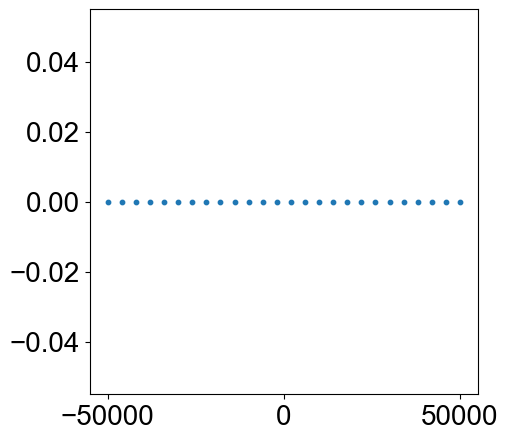

In [ ]:

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = 10

rec_x = (rx_locs.astype(float) )[:, 0]
rec_y = (rx_locs.astype(float) )[:, 1]
ax.scatter(rec_x, rec_y, label=f'$db_z/dt$ ', s=10, zorder=2)


plt.show()

## mesh

In [ ]:
from discretize import TensorMesh

# Calculate the overall extent of survey lines and points
all_xyz = np.vstack([*rx_locs])
x_min, x_max = all_xyz[:, 0].min(), all_xyz[:, 0].max()
z_min, z_max = -40000, 0  # Adjust if necessary based on the actual survey domain

# Cell size in the main (core) region
dx = 1000
dh = 1000

# Number of padding cells
pad_num = 6

# Number of cells in the core region
core_num_x = int(np.ceil((x_max - x_min) / dx))
core_num_z = int(np.ceil((z_max - z_min) / dh))

# Setup grid parameters for each direction
hx = [(dx, pad_num, -2.2), (dx, core_num_x), (dx, pad_num, 2.2)]
hz = [(dh, pad_num, -2), (dh, core_num_z), (dh, pad_num, 2)]

# Center x0 to align with the center of the line and with z=0 at the surface
center_x = (x_min + x_max) / 2

# Center horizontally and set z=0 at the surface
mesh = TensorMesh([hx, hz])  # Instantiate the mesh
x0 = [
    center_x - mesh.h[0].sum() / 2,  # Center in X direction
    -mesh.h[-1][:core_num_z + pad_num].sum()  # Set Z origin at the surface
]

mesh.x0 = x0

tensor_mesh = mesh
mesh


TensorMesh: 5,824 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    112   -256,029.82    256,029.82  1,000.00 113,379.90    2.20
   y     52   -166,000.00    126,000.00  1,000.00 64,000.00    2.00

<Axes: xlabel='x1', ylabel='x2'>

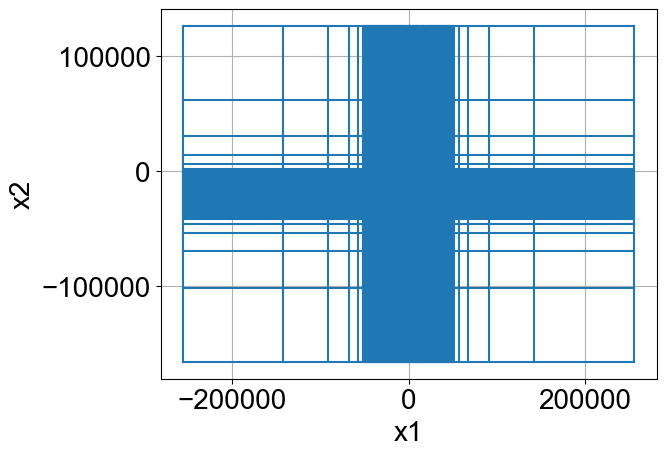

In [82]:
mesh.plot_grid(figsize=(10, 4))

In [83]:
from simpeg.maps import IdentityMap
from discretize.utils import ndgrid,mkvc,sdiag

class NewMap(IdentityMap):

    def __init__(self, mesh=None, nP=None, a=1,b=2000,**kwargs):
        super().__init__(mesh=mesh, nP=nP, **kwargs)
        self.a = a
        self.b = b

    def _transform(self, m):
        return (self.a+self.b *np.exp(mkvc(m)) )/(1+np.exp(mkvc(m)))

    def inverse(self, D):
 
        return np.log(mkvc(D)-self.a)-np.log(self.b -mkvc(D))

    def deriv(self, m, v=None):

        diag_vals = ((self.b - self.a)* np.exp(mkvc(m))) / (1+np.exp(mkvc(m)))**2
        deriv = sdiag(diag_vals)

        if v is not None:
            return deriv * v
        return deriv

    @property
    def is_linear(self):
        return False


In [84]:
active_cells = tensor_mesh.cell_centers[:, -1] < 0.0
nC = int(np.sum(active_cells))

a = 1
b = 5000

mapping = maps.InjectActiveCells(tensor_mesh, active_cells,1e8)* NewMap(a=a,b=b)

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    rhoMap=mapping,
)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    rhoMap=mapping,
)

## 构建模型

In [85]:
from simpeg.utils import plot2Ddata, model_builder, download


In [ ]:
background = (800)

mt_model = np.ones(nC).reshape(46,112)[:,:]


def return_model(data):
    data = data[:,:]
    model_return=data.ravel(order='F')
    return model_return.reshape(-1)




mt_model = (np.load('case2.npy'))



# mt_model = mt_model[:,:].reshape(-1,)
mt_model.shape

(5152,)

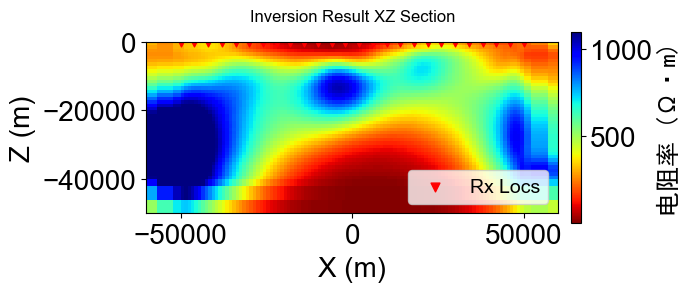

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
cmap = 'jet_r'

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

vmin, vmax = 1, 1100
im = mesh.plot_image(
    ((mapping * mt_model)),
    grid=False,
    pcolor_opts={'cmap': cmap, 'vmin': vmin, 'vmax': vmax},
    ax=ax
)

ax.set_ylabel('Z (m)', labelpad=5)
ax.set_xlabel('X (m)', labelpad=5)
ax.set_title("Inversion Result XZ Section", pad=15)
ax.tick_params(axis='both', which='major')
ax.set_aspect('equal')
ax.set_xlim([-60000, 60000])
ax.set_ylim([-50000, 000])

# rx_locs
rx_locs = np.array(survey_te.source_list[0].receiver_list[0].locations)  

if rx_locs.shape[1] == 3:
    ax.scatter(rx_locs[:,0], rx_locs[:,1], color="red", s=40, marker="v", label="Rx Locs")
elif rx_locs.shape[1] == 2:
    ax.scatter(rx_locs[:,0], rx_locs[:,1], color="red", s=40, marker="v", label="Rx Locs")
ax.legend(fontsize=14, loc="lower right")

cbar = plt.colorbar(im[0], ax=ax, fraction=0.022, pad=0.03)
cbar.set_label('resistivity (Ω·m)', fontsize=18, family='SimHei')

plt.tight_layout()
plt.show()


In [89]:
dobs_te = sim_te.dpred(mt_model)
dobs_tm = sim_tm.dpred(mt_model)

np.random.seed(0)
relative_error = 0.03
dobs_te += abs(dobs_te) * relative_error * np.random.randn(dobs_te.size)
dobs_tm += abs(dobs_tm) * relative_error * np.random.randn(dobs_tm.size)


dobs = np.concatenate([dobs_tm, dobs_te])
std_te =0.05*np.abs(dobs_te)
std_tm =0.05*np.abs(dobs_tm)


In [90]:
first_model = np.ones(nC) * 500
# first_model = np.log(1/first_model)

first_model = np.log(first_model-a)-np.log(b -first_model)
first_model.shape

(5152,)

In [91]:
te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)

dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)

dmis = dmis_tm + dmis_te 


In [92]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf


from scipy.sparse import csr_matrix, diags
from simpeg.regularization import BaseRegularization
from simpeg import maps

In [ ]:


os.chdir('..')
loaded_model = tf.keras.models.load_model('./model_train/reg_model.h5',)
mask_model = tf.keras.models.load_model('./model_train/imaging_model.h5')




In [ ]:

class BetaExpDecayAndSmoothNet(directives.InversionDirective):

    def __init__(self,beta0=10.0, beta_min=0.01, n_iter_target=10):
        super().__init__()
        self.beta0 = float(beta0)
        self.beta_min = float(beta_min)
        self.decay_factor = (self.beta_min / self.beta0) ** (1 / float(n_iter_target))

    def endIter(self):

        # 2.  beta
        iteration = self.opt.iter
        new_beta = self.beta0 * (self.decay_factor ** iteration)
        new_beta = max(new_beta, self.beta_min)
        self.invProb.beta = new_beta


class SavePhi(directives.InversionDirective):
    def initialize(self):
        self.rms_lci = []

    def endIter(self):
        noise_std = 0.05 * np.abs(dobs)
        rms_lci = np.sqrt(np.mean( ((self.invProb.dpred - dobs) / noise_std) ** 2))
        self.rms_lci.append(rms_lci)

        print(f" RMS={rms_lci:.3e}")

# Define the regularization (model objective function)
dy = mesh.h[1].min()
dx = mesh.h[0].min()
reg_lci = regularization.WeightedLeastSquares(
    tensor_mesh,
    alpha_s=1e-10,
    alpha_x = 1,alpha_y =1,
    active_cells=tensor_mesh.cell_centers[:, -1]< 0.0,
    

)


reg =  reg_lci  
opt = optimization.ProjectedGNCG(maxIter=20, maxIterCG=10, maxIterLS=10)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)


starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=3)

save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}

BetaExpDecayAndSmoothNet = BetaExpDecayAndSmoothNet(beta0=1e-2, beta_min=1e-4, n_iter_target=20)


# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)
SavePhi = SavePhi()
directives_list = [
    #starting_beta,
    #beta_schedule,
    BetaExpDecayAndSmoothNet,
    target_misfit,
    SavePhi
]


mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = mt_inversion.run(first_model)



Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DElectricField problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  7.03e+06  0.00e+00  7.03e+06    3.16e+06      0              
 RMS=1.929e+01
   1  7.94e-03  7.74e+05  8.40e+00  7.

## 结果展示

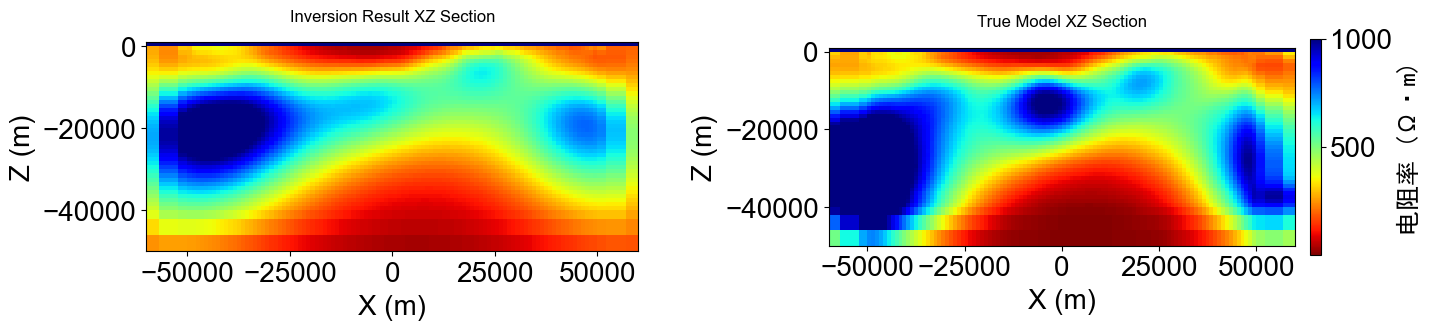

In [ ]:
# Plot two figures: Inversion Result and True Model XZ Section
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
cmap = 'jet_r'

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Set minimum and maximum values for color scale
vmin, vmax = 1, 1e3  # Set reasonable min and max values as needed
# Plot inversion result on the left
im = mesh.plot_image(
    np.abs((mapping * recovered_conductivity_model)),
    grid=False,
    pcolor_opts={'cmap': cmap, 'vmin': vmin, 'vmax': vmax},
    ax=axes[0]
)
# Plot true model on the right
im = mesh.plot_image(
    np.abs((mapping * mt_model)),
    grid=False,
    pcolor_opts={'cmap': cmap, 'vmin': vmin, 'vmax': vmax},
    ax=axes[1]
)
for i in range(2):
    axes[i].set_ylabel('Z (m)', labelpad=5)
    axes[i].set_xlabel('X (m)', labelpad=5)
    if i == 0:
        axes[i].set_title("Inversion Result XZ Section", pad=15)
    else:
        axes[i].set_title("True Model XZ Section", pad=15)
    axes[i].tick_params(axis='both', which='major')
    axes[i].set_aspect('equal')
    axes[i].set_xlim([-60000, 60000])
    axes[i].set_ylim([-50000, 1000])

# Add colorbar and set label (in Chinese font for demonstration)
cbar = plt.colorbar(im[0], ax=axes[1], fraction=0.022, pad=0.03)
cbar.set_label('Resistivity (Ω·m)', fontsize=18, family='SimHei')  # English label

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [96]:
pred_data = inv_prob.dpred

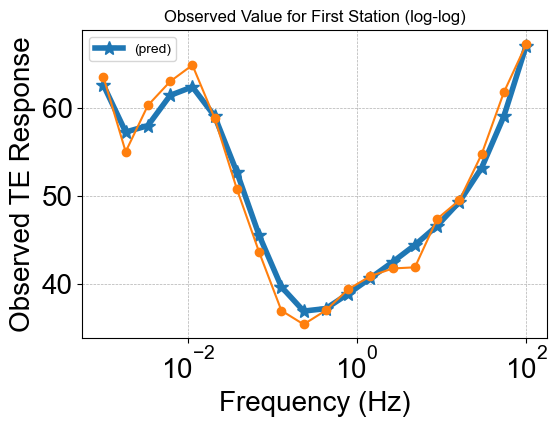

array([64.79114284, 58.99369396, 58.83424358, 61.79028146, 61.03930663,
       57.89351451, 52.68924817, 47.72328849, 40.99633646, 41.10003337,
       39.36699725, 39.32829575, 43.61153251, 44.12690698, 46.10160291,
       47.3369214 , 46.89212211, 48.74404544, 54.87975345, 60.0707662 ])

In [97]:
from cProfile import label

pred_te = pred_data[dobs_tm.shape[0]:]
pred_te = pred_te.reshape(n_freq,2,n_rx)
obs_2d = pred_te.reshape(n_freq,2,n_rx)
pred_2d = dobs_te.reshape(n_freq,2,n_rx)

# 与 frequency 绘制 loglog 图像
plt.figure(figsize=(6,4))
plt.plot((frequencies), (obs_2d[:,1,5]), marker='*', label='(pred)', markersize=10, linewidth=4)
plt.plot(frequencies, pred_2d[:,1,5], marker='o')
plt.xscale('log')

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Observed TE Response")
plt.title("Observed Value for First Station (log-log)")
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()
pred_2d[:,1,0]

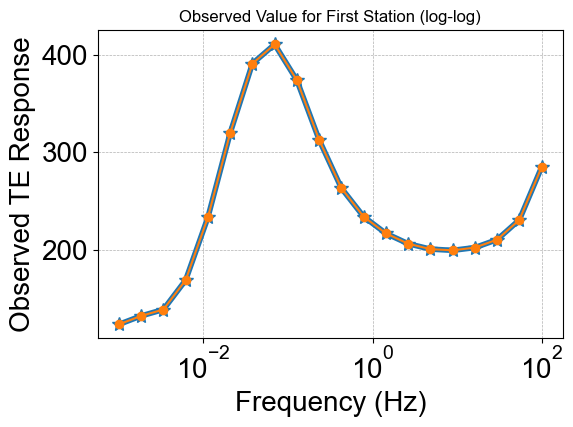

In [98]:
pred_tm = pred_data[dobs_te.shape[0]:]

obs_2d = pred_tm.reshape(n_freq,2,n_rx)
pred_2d = pred_tm.reshape(n_freq,2,n_rx)

# 与 frequency 绘制 loglog 图像
plt.figure(figsize=(6,4))
plt.plot(frequencies, obs_2d[:,0,5], marker='*', label='(pred)', markersize=10, linewidth=4)
plt.plot(frequencies, pred_2d[:,0,5], marker='o')
plt.xscale('log')

plt.xlabel("Frequency (Hz)")
plt.ylabel("Observed TE Response")
plt.title("Observed Value for First Station (log-log)")
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()


In [99]:
SavePhi.rms_lci

[19.288045420319055,
 5.549060875228465,
 1.9147932381299477,
 1.3839009227798593,
 1.1677857930211495,
 1.0203088663312943,
 0.9469343054781785]

In [ ]:
np.save('mt_case\RMS_all_lci.npy',SavePhi.rms_lci)
np.save('inv_lci.npy', mapping * recovered_conductivity_model)